In [ ]:
!pip install datasets transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from datasets import load_dataset
import warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
import gc
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

# ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# load dataset
dataset = load_dataset("samzirbo/europarl.en-es.gendered")

print("Libraries and datasets loaded!")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/144 [00:00<?, ?B/s]

europarl.en-es.simple.json:   0%|          | 0.00/526M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1419507 [00:00<?, ? examples/s]

Libraries and datasets loaded!


In [ ]:
# convert to pandas
df = dataset['train'].to_pandas()

# remove neutral samples
df = df[df['gender'] != 'neutral']

# balance classes by random undersampling
min_samples = df['gender'].value_counts().min()
df_balanced = df.groupby('gender').apply(lambda x: x.sample(min_samples, random_state=63)).reset_index(drop=True)

# only keep English text
df_balanced = df_balanced[['en', 'gender']]

df_balanced

<ipython-input-3-9b4bd2eeaa31>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('gender').apply(lambda x: x.sample(min_samples, random_state=63)).reset_index(drop=True)


en  gender
0       The first mine in the world to use microbial e...  female
1       Men occupy two-thirds of all jobs in new techn...  female
2       I believe , in fact , that the only effective ...  female
3       That being the case , I cannot believe , liste...  female
4       We cannot continue to ignore this problem and ...  female
...                                                   ...     ...
742303  Most important of all , we need a system of tr...    male
742304  The main person to subvert this concept , from...    male
742305  If you have a question for the Council , then ...    male
742306  However , I regret to say that the attached fo...    male
742307  How can one talk about development policy , wh...    male

[742308 rows x 2 columns]

In [ ]:
# encode labels
label_encoder = LabelEncoder()
df_balanced['label'] = label_encoder.fit_transform(df_balanced['gender'])

df_balanced

en  gender  label
0       The first mine in the world to use microbial e...  female      0
1       Men occupy two-thirds of all jobs in new techn...  female      0
2       I believe , in fact , that the only effective ...  female      0
3       That being the case , I cannot believe , liste...  female      0
4       We cannot continue to ignore this problem and ...  female      0
...                                                   ...     ...    ...
742303  Most important of all , we need a system of tr...    male      1
742304  The main person to subvert this concept , from...    male      1
742305  If you have a question for the Council , then ...    male      1
742306  However , I regret to say that the attached fo...    male      1
742307  How can one talk about development policy , wh...    male      1

[742308 rows x 3 columns]

In [ ]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(df_balanced['en'], df_balanced['label'], test_size=0.22, random_state=63)

# load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-large")
model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-large", num_labels=2)

# define dataset class
class GenderDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

# create datasets
train_dataset = GenderDataset(X_train, y_train, tokenizer)
test_dataset = GenderDataset(X_test, y_test, tokenizer)

# define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_steps=500,
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none",
    gradient_accumulation_steps=2,
    warmup_steps=500,
)

# define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

# training model
trainer.train()

# saving model
trainer.save_model("./gc")
tokenizer.save_pretrained("./gc")

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/874M [00:00<?, ?B/s]

('./gc/tokenizer_config.json',
 './gc/special_tokens_map.json',
 './gc/spm.model',
 './gc/added_tokens.json',
 './gc/tokenizer.json')

Classification Report:
              precision    recall  f1-score   support

      female       0.59      0.69      0.64     81810
        male       0.62      0.51      0.56     81498

    accuracy                           0.60    163308
   macro avg       0.61      0.60      0.60    163308
weighted avg       0.61      0.60      0.60    163308



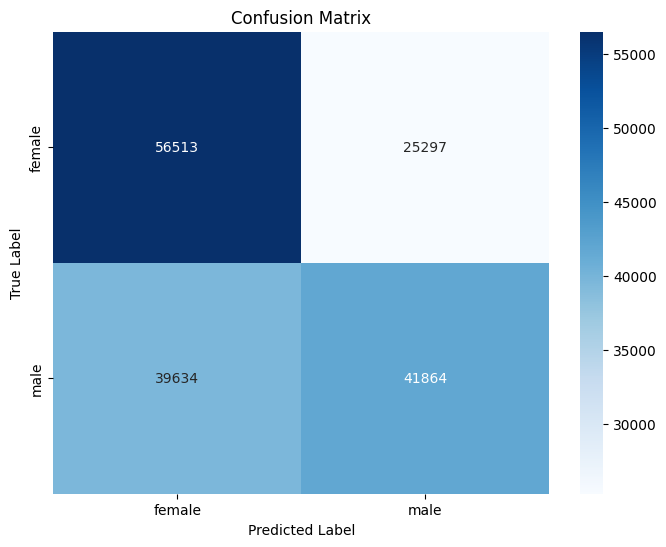

In [9]:
# visualization
predictions = trainer.predict(test_dataset)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

# classification report
print("Classification Report:")
print(classification_report(y_test, predicted_labels, target_names=label_encoder.classes_))

# confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()